In [24]:
import os
import random
import requests
import warnings
from datetime import datetime
from datetime import datetime, timedelta

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import itertools


# Suppress warnings
warnings.filterwarnings('ignore')

# Statistical and ML libraries
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif

# Time series specific libraries
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from scipy import stats 

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [36]:
# Define the file paths
path1 = r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'
path2 = r'C:\Users\TPWODL\New folder_Content\TimeSeriesForecasting_End_To_End\data\timeseries_model_data.csv'

# Check which path exists and read CSV
if os.path.exists(path1):
    new_df = pd.read_csv(path1) 
elif os.path.exists(path2):
    new_df = pd.read_csv(path2)   
else:
    # Raise a FileNotFoundError if neither path is valid
    raise FileNotFoundError("❌ No valid data file found in either specified path.")

In [37]:
new_df["time"] = pd.to_datetime(new_df["time"])
df = new_df.drop(columns=['relative_humidity_2m_mean','weather_label', 'Complaint_Count_diff1','year',"month"])
df['day_of_month'] = df['time'].dt.day
df['day_of_year'] = df['time'].dt.dayofyear
# Day of Week (7 days cycle)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# Day of Month (approx 31 days cycle)
df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

# Day of Year (365 days cycle)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df.drop(['day_of_week', 'day_of_month', 'day_of_year'], axis=1, inplace=True)
df.set_index('time', inplace=True)
df

,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
time,,,,,,,,,,
2022-06-10,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
2022-06-11,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2022-06-12,39.8,0.0,16.7,5,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
2022-06-13,40.2,0.0,13.3,15,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
2022-06-14,39.2,8.6,19.0,16,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967
...,...,...,...,...,...,...,...,...,...,...
2025-10-15,31.4,0.0,6.1,18,0.974928,-0.222521,0.101168,-0.994869,-0.970064,0.242850
2025-10-16,30.9,0.0,8.2,18,0.433884,-0.900969,-0.101168,-0.994869,-0.965740,0.259512
2025-10-17,31.0,0.0,7.8,17,-0.433884,-0.900969,-0.299363,-0.954139,-0.961130,0.276097


In [38]:
df.reset_index(inplace=True)

In [39]:
df

,time,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
0,2022-06-10,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
1,2022-06-11,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2,2022-06-12,39.8,0.0,16.7,5,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
3,2022-06-13,40.2,0.0,13.3,15,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
4,2022-06-14,39.2,8.6,19.0,16,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967
...,...,...,...,...,...,...,...,...,...,...,...
1178,2025-10-15,31.4,0.0,6.1,18,0.974928,-0.222521,0.101168,-0.994869,-0.970064,0.242850
1179,2025-10-16,30.9,0.0,8.2,18,0.433884,-0.900969,-0.101168,-0.994869,-0.965740,0.259512
1180,2025-10-17,31.0,0.0,7.8,17,-0.433884,-0.900969,-0.299363,-0.954139,-0.961130,0.276097
1181,2025-10-18,30.5,0.0,6.3,37,-0.974928,-0.222521,-0.485302,-0.874347,-0.956235,0.292600


In [16]:
# PREPARE DATA FOR 30-DAY FORECASTING
# Use all data for training to get best model
X_all = df.drop(columns=['Complaint_Count'])
y_all = df['Complaint_Count']

# Scale all features and target
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_all_scaled = scaler_X.fit_transform(X_all)
y_all_scaled = scaler_y.fit_transform(y_all.values.reshape(-1, 1))


In [18]:
# Create sequences
def create_sequences(X, y, lookback=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:i+lookback])
        y_seq.append(y[i+lookback])
    return np.array(X_seq), np.array(y_seq)

lookback = 5
X_all_seq, y_all_seq = create_sequences(X_all_scaled, y_all_scaled, lookback)

print(f"Training on complete dataset - Shape: {X_all_seq.shape}")

Training on complete dataset - Shape: (1178, 5, 9)


In [20]:
X_all_seq[0]

array([[8.33333333e-01, 6.45994832e-04, 3.72483221e-01, 2.77479066e-01,
        0.00000000e+00, 9.49479173e-01, 2.77950623e-01, 6.80858540e-01,
        3.38374997e-02],
       [8.33333333e-01, 1.29198966e-03, 6.64429530e-01, 0.00000000e+00,
        3.56895868e-01, 8.95895998e-01, 1.91873892e-01, 6.72807757e-01,
        3.07933540e-02],
       [7.83333333e-01, 0.00000000e+00, 3.75838926e-01, 9.90311321e-02,
        8.01937736e-01, 8.26104795e-01, 1.18359232e-01, 6.64705766e-01,
        2.78882416e-02],
       [8.00000000e-01, 0.00000000e+00, 2.61744966e-01, 5.00000000e-01,
        1.00000000e+00, 7.42962822e-01, 6.04163420e-02, 6.56554970e-01,
        2.51230235e-02],
       [7.58333333e-01, 5.55555556e-02, 4.53020134e-01, 9.00968868e-01,
        8.01937736e-01, 6.49873924e-01, 2.04174111e-02, 6.48357783e-01,
        2.24985188e-02]])

In [21]:
y_all_seq[0]

array([0.16666667])

In [25]:
# TRAIN MODEL ON FULL DATASET

tf.random.set_seed(42)
np.random.seed(42)

model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(lookback, X_all_seq.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=True),
    Dropout(0.2),
    LSTM(units=16, return_sequences=False),
    Dropout(0.2),
    Dense(units=8, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)

print("\n" + "="*60)
print("TRAINING ON FULL DATASET FOR 30-DAY FORECAST...")
print("="*60)

history = model.fit(
    X_all_seq, y_all_seq,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n" + "="*60)
print("MODEL TRAINED - READY FOR FORECASTING")
print("="*60)

# ============================================================================
# PREPARE LAST SEQUENCE FOR FORECASTING
# ============================================================================

last_sequence = X_all_scaled[-lookback:].copy()
print(f"\nLast sequence shape: {last_sequence.shape}")



TRAINING ON FULL DATASET FOR 30-DAY FORECAST...
Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0684 - mae: 0.2219 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0492 - mae: 0.1754 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0432 - mae: 0.1639 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - mae: 0.1496 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0380 - mae: 0.1490 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381 - mae: 0.1507 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374 - mae: 0.1482 - learning_rate: 0.0010
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0376 - mae: 0.1494 - learning_rate: 0.0010
Epoch 9/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0374 - mae: 0.1473 - learning_rate: 0.0010
Epoch 10/100
37

In [26]:
# PREPARE LAST SEQUENCE FOR FORECASTING

last_sequence = X_all_scaled[-lookback:].copy()
print(f"\nLast sequence shape: {last_sequence.shape}")


Last sequence shape: (5, 9)


In [27]:
# PREPARE LAST SEQUENCE FOR FORECASTING

last_sequence = X_all_scaled[-lookback:].copy()
print(f"\nLast sequence shape: {last_sequence.shape}")

# FORECAST NEXT 30 DAYS
forecast_days = 30
forecast_predictions = []
current_sequence = last_sequence.copy()

print("\n" + "="*60)
print("GENERATING 30-DAY FORECAST...")
print("="*60)

for day in range(forecast_days):
    # Predict next value
    next_pred_scaled = model.predict(current_sequence.reshape(1, lookback, current_sequence.shape[1]), verbose=0)
    forecast_predictions.append(next_pred_scaled[0, 0])
    
    # Create feature vector for next day (using average of recent patterns)
    # This is a placeholder - adjust based on your actual features
    avg_features = np.mean(current_sequence, axis=0)
    next_features = avg_features.copy()
    next_features[-1] = next_pred_scaled[0, 0]  # Update with prediction
    
    # Update sequence - remove first row, add new prediction
    current_sequence = np.vstack([current_sequence[1:], next_features.reshape(1, -1)])
    
    if (day + 1) % 10 == 0:
        print(f"  Completed: {day + 1}/{forecast_days} days")

# Convert predictions back to original scale
forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)
forecast_predictions_actual = scaler_y.inverse_transform(forecast_predictions)


Last sequence shape: (5, 9)

GENERATING 30-DAY FORECAST...
  Completed: 10/30 days
  Completed: 20/30 days
  Completed: 30/30 days


In [45]:
# CREATE FORECAST DATAFRAME
# Get last date from original data
last_date = pd.to_datetime(df['time'].iloc[-1])

# Generate future dates
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Complaint_Count': forecast_predictions_actual.flatten(),
    'Day_Ahead': range(1, forecast_days + 1)
})

print("\n" + "="*60)
print("30-DAY FORECAST RESULTS")
print("="*60)
print(forecast_df.to_string(index=False))


30-DAY FORECAST RESULTS
      Date  Forecasted_Complaint_Count  Day_Ahead
2025-10-20                   19.621193          1
2025-10-21                   20.158293          2
2025-10-22                   22.340145          3
2025-10-23                   26.379673          4
2025-10-24                   32.525822          5
2025-10-25                   38.285004          6
2025-10-26                   37.262562          7
2025-10-27                   35.301033          8
2025-10-28                   32.906734          9
2025-10-29                   31.076853         10
2025-10-30                   30.775496         11
2025-10-31                   31.821627         12
2025-11-01                   32.870190         13
2025-11-02                   33.574226         14
2025-11-03                   33.768181         15
2025-11-04                   33.482803         16
2025-11-05                   32.984341         17
2025-11-06                   32.656265         18
2025-11-07               

In [34]:
df.reset_index(inplace=True)

In [35]:
df

,index,temp_max_C,precip_mm,wind_speed_max_m_s,Complaint_Count,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos
0,0,41.0,0.1,16.6,10,-0.433884,-0.900969,0.897805,-0.440394,0.361714,-0.932289
1,1,41.0,0.2,25.3,12,-0.974928,-0.222521,0.790776,-0.612106,0.345612,-0.938377
2,2,39.8,0.0,16.7,5,-0.781831,0.623490,0.651372,-0.758758,0.329408,-0.944188
3,3,40.2,0.0,13.3,15,0.000000,1.000000,0.485302,-0.874347,0.313107,-0.949718
4,4,39.2,8.6,19.0,16,0.781831,0.623490,0.299363,-0.954139,0.296713,-0.954967
...,...,...,...,...,...,...,...,...,...,...,...
1178,1178,31.4,0.0,6.1,18,0.974928,-0.222521,0.101168,-0.994869,-0.970064,0.242850
1179,1179,30.9,0.0,8.2,18,0.433884,-0.900969,-0.101168,-0.994869,-0.965740,0.259512
1180,1180,31.0,0.0,7.8,17,-0.433884,-0.900969,-0.299363,-0.954139,-0.961130,0.276097
1181,1181,30.5,0.0,6.3,37,-0.974928,-0.222521,-0.485302,-0.874347,-0.956235,0.292600


In [40]:
# Get last date from original data
last_date = pd.to_datetime(df['time'].iloc[-1])

# Generate future dates
future_dates = [last_date + timedelta(days=i+1) for i in range(forecast_days)]

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Complaint_Count': forecast_predictions_actual.flatten(),
    'Day_Ahead': range(1, forecast_days + 1)
})

print("\n" + "="*60)
print("30-DAY FORECAST RESULTS")
print("="*60)
print(forecast_df.to_string(index=False))


30-DAY FORECAST RESULTS
      Date  Forecasted_Complaint_Count  Day_Ahead
2025-10-20                   19.621193          1
2025-10-21                   20.158293          2
2025-10-22                   22.340145          3
2025-10-23                   26.379673          4
2025-10-24                   32.525822          5
2025-10-25                   38.285004          6
2025-10-26                   37.262562          7
2025-10-27                   35.301033          8
2025-10-28                   32.906734          9
2025-10-29                   31.076853         10
2025-10-30                   30.775496         11
2025-10-31                   31.821627         12
2025-11-01                   32.870190         13
2025-11-02                   33.574226         14
2025-11-03                   33.768181         15
2025-11-04                   33.482803         16
2025-11-05                   32.984341         17
2025-11-06                   32.656265         18
2025-11-07               

In [41]:
# STATISTICS

print("\n" + "="*60)
print("FORECAST STATISTICS")
print("="*60)
print(f"Mean Predicted Complaints:    {forecast_predictions_actual.mean():.2f}")
print(f"Std Dev:                      {forecast_predictions_actual.std():.2f}")
print(f"Min Predicted:                {forecast_predictions_actual.min():.2f}")
print(f"Max Predicted:                {forecast_predictions_actual.max():.2f}")
print(f"Median Predicted:             {np.median(forecast_predictions_actual):.2f}")


FORECAST STATISTICS
Mean Predicted Complaints:    31.75
Std Dev:                      4.15
Min Predicted:                19.62
Max Predicted:                38.29
Median Predicted:             32.88


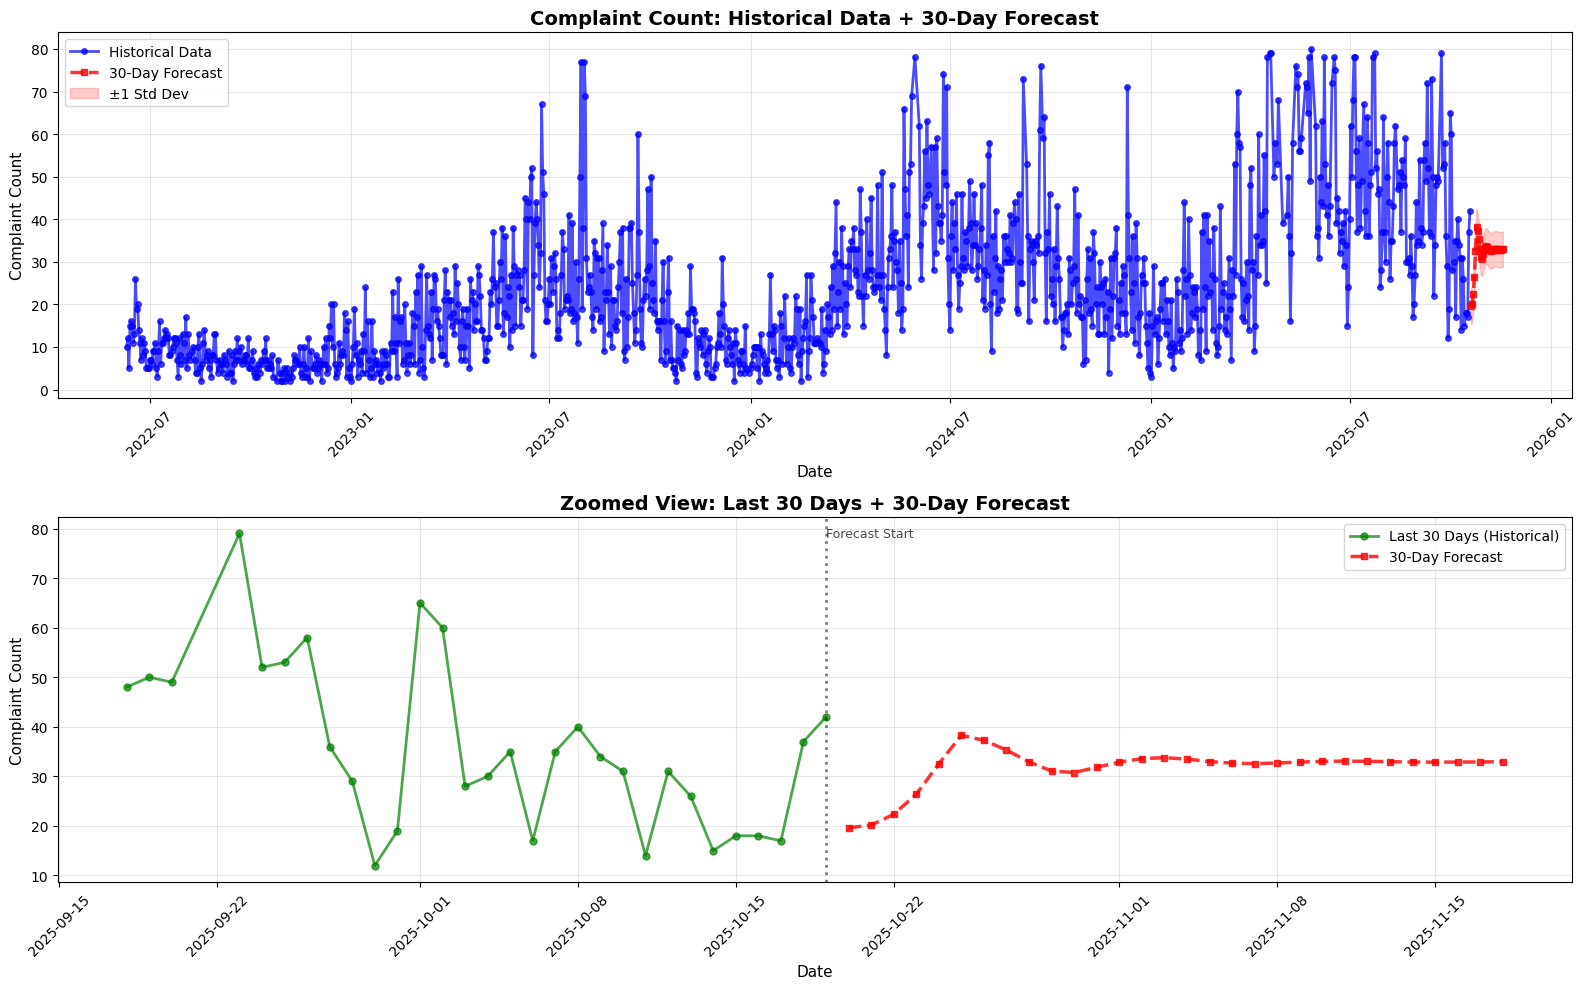

In [42]:
# VISUALIZATION - HISTORICAL + FORECAST

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Complete Timeline (Historical + Forecast)
ax1 = axes[0]

# Historical data
historical_dates = pd.to_datetime(df['time'])
ax1.plot(historical_dates, df['Complaint_Count'], label='Historical Data', 
         marker='o', linewidth=2, markersize=4, color='blue', alpha=0.7)

# Forecast
ax1.plot(forecast_df['Date'], forecast_df['Forecasted_Complaint_Count'], 
         label='30-Day Forecast', marker='s', linewidth=2.5, markersize=5, 
         color='red', alpha=0.8, linestyle='--')

# Confidence band (±1 std)
std_forecast = forecast_predictions_actual.std()
upper_band = forecast_df['Forecasted_Complaint_Count'] + std_forecast
lower_band = forecast_df['Forecasted_Complaint_Count'] - std_forecast
ax1.fill_between(forecast_df['Date'], lower_band, upper_band, alpha=0.2, color='red', label='±1 Std Dev')

# Formatting
ax1.set_title('Complaint Count: Historical Data + 30-Day Forecast', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Complaint Count', fontsize=11)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Zoomed Forecast (Last 30 historical + 30 forecast)
ax2 = axes[1]

# Last 30 days of historical
last_30_dates = historical_dates.iloc[-30:]
last_30_complaints = df['Complaint_Count'].iloc[-30:]

ax2.plot(last_30_dates, last_30_complaints, label='Last 30 Days (Historical)', 
         marker='o', linewidth=2, markersize=5, color='green', alpha=0.7)
ax2.plot(forecast_df['Date'], forecast_df['Forecasted_Complaint_Count'], 
         label='30-Day Forecast', marker='s', linewidth=2.5, markersize=5, 
         color='red', alpha=0.8, linestyle='--')

# Add vertical line at transition
transition_date = last_date
ax2.axvline(x=transition_date, color='black', linestyle=':', linewidth=2, alpha=0.5)
ax2.text(transition_date, ax2.get_ylim()[1]*0.95, 'Forecast Start', 
         rotation=0, fontsize=9, alpha=0.7)

# Formatting
ax2.set_title('Zoomed View: Last 30 Days + 30-Day Forecast', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Complaint Count', fontsize=11)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [43]:
# WEEKLY AGGREGATED FORECAST   
forecast_df['Week'] = (forecast_df['Day_Ahead'] - 1) // 7 + 1
weekly_forecast = forecast_df.groupby('Week').agg({
    'Forecasted_Complaint_Count': ['sum', 'mean', 'min', 'max']
}).round(2)

print("\n" + "="*60)
print("WEEKLY AGGREGATED FORECAST (30 DAYS = 4+ WEEKS)")
print("="*60)
print(weekly_forecast)
 


WEEKLY AGGREGATED FORECAST (30 DAYS = 4+ WEEKS)
     Forecasted_Complaint_Count                                 
                            sum       mean        min        max
Week                                                            
1                    196.570007  28.080000  19.620001  38.290001
2                    228.330002  32.619999  30.780001  35.299999
3                    231.029999  33.000000  32.570000  33.770000
4                    230.720001  32.959999  32.860001  33.070000
5                     65.849998  32.930000  32.910000  32.939999


In [44]:
print("30-DAY FORECASTING COMPLETE!")

30-DAY FORECASTING COMPLETE!
